In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! pip install tensorflow==2.2.0

In [ ]:
!pip install  keras==2.3.1

In [6]:
### Importing the required libraries

import os
import warnings
warnings.filterwarnings('ignore')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.layers import concatenate
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input,Conv2D,Conv1D,MaxPool2D,Activation,BatchNormalization
from tensorflow.keras.layers import Multiply,Add
from tensorflow.keras.layers import UpSampling2D
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score,mean_absolute_error

import datetime


In [ ]:
### Importing and unzipping the data from Gdrive
!unzip '/content/drive/MyDrive/NJU2K.zip' -d '/content/NJU2K'

In [8]:
### Creating the DataFrame with the paths of RGB,Depth and GT images

def return_images_df(path):
    # writing  the code that will create a dataframe with two columns ['RGB', 'Depth','GT']
    # the column 'RGB' will have path to RGB images
    # the column 'Depth' will have path to Depth images
    # The column 'GT' will have path to Ground Truth images
    RGB_images=[]
    Depth_images=[]
    GT_images=[]
    for i in os.listdir(path):
      if i=='GT-1985':
        for j in sorted(os.listdir(os.path.join(path,i))):
          GT_images.append(os.path.join(os.path.join(path,i),j))
    
      if i=='RGB_bmp':
        for j in sorted(os.listdir(os.path.join(path,i))):
          RGB_images.append(os.path.join(os.path.join(path,i),j))

      if i=='depth':
        for j in sorted(os.listdir(os.path.join(path,i))):
          Depth_images.append(os.path.join(os.path.join(path,i),j))
    
    dict={'RGB':RGB_images,'Depth':Depth_images,'GT':GT_images}
    
    data_df=pd.DataFrame(dict)

    return data_df

In [9]:
## Creating the DataFrame
root_dir='/content/NJU2K/NJU2K'
data_df = return_images_df(root_dir)
print(data_df.shape)
data_df.head()

(1985, 3)


RGB  ...                                            GT
0  /content/NJU2K/NJU2K/RGB_bmp/000001_left.bmp  ...  /content/NJU2K/NJU2K/GT-1985/000001_left.png
1  /content/NJU2K/NJU2K/RGB_bmp/000002_left.bmp  ...  /content/NJU2K/NJU2K/GT-1985/000002_left.png
2  /content/NJU2K/NJU2K/RGB_bmp/000003_left.bmp  ...  /content/NJU2K/NJU2K/GT-1985/000003_left.png
3  /content/NJU2K/NJU2K/RGB_bmp/000004_left.bmp  ...  /content/NJU2K/NJU2K/GT-1985/000004_left.png
4  /content/NJU2K/NJU2K/RGB_bmp/000005_left.bmp  ...  /content/NJU2K/NJU2K/GT-1985/000005_left.png

[5 rows x 3 columns]

In [10]:
### Creating the Dataloader 

class Dataset:
   
    def __init__(self, data,w=160,h=160):
        
      
        self.ids = data
        
        self.RGB_images   = [RGB[0] for RGB in self.ids]                        # the paths of RGB images
        
        self.Depth_images    = [Depth[1] for Depth in self.ids]                 # the paths of Depth images
        
        self.GT_images    = [GT[2] for GT in self.ids]                          # the paths of Ground Truth images

        self.class_values=[0,255]                                               ## Creating the two different channels for two classes i.e binary classes

        self.w = w
        self.h = h                                                            ## Resizing the image 
    
    def __getitem__(self, i):
        
        # read data
        
        RGB_image = cv2.imread(self.RGB_images[i], cv2.IMREAD_UNCHANGED)

        RGB_image =cv2.resize(RGB_image,(self.w,self.h),interpolation=cv2.INTER_AREA)   ## Loading the RGB image and resizing it to required size

        RGB_image=RGB_image/255

        Depth_image = cv2.imread(self.Depth_images[i]) 

        Depth_image =cv2.resize(Depth_image,(self.w,self.h),interpolation=cv2.INTER_AREA)  ## Loading the Depth image and resizing it to required size
        
        Depth_image=Depth_image/255
       

        GT_image = cv2.imread(self.GT_images[i],0) 

        GT_image_init =cv2.resize(GT_image,(self.w,self.h),interpolation=cv2.INTER_AREA)    ## Loading the Ground Truth image and resizing it to required size

        GT_images=[np.where((GT_image_init == v),1,0).astype('float32') for v in self.class_values]   ## Creating two channels for two classes

        GT_image=np.stack(GT_images, axis=-1).astype('float')                                       ### Stacking these channels
      

        GT_image_global=MaxPool2D(pool_size=(8,8),strides=(8,8))(np.expand_dims(GT_image_init,axis=(0,3)))   ## Downsizing the Ground truth image for Coarse predicction comparision
      
        GT_image_global=np.reshape(GT_image_global,(20,20))                     ### Reshaping the image to required size

        GT_image_globals=[np.where((GT_image_global == v),1,0).astype('float32') for v in self.class_values]   ## Creating two channels for two classes

        GT_image_global=np.stack(GT_image_globals, axis=-1).astype('float')           ### Stacking these channels
 

        return RGB_image,Depth_image,GT_image,GT_image_global           ## Returning the images
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):       ## Dataloader for train and test dataset
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
 
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.stack(samples,axis=0) for samples in zip(*data)]   ## Stacking the samples according to the batch size

        batch=[[batch[0],batch[1]],[batch[3],batch[3],batch[2]]]    ### Creating the data into required format i.e [[x,x],[y,y,y]]
    
        
        return tuple(batch)   ## returning the Data samples
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)  ## Doing the shuffling after every epoch

In [11]:
### Splitting the Dataset into Train and test
X_train, X_test = train_test_split(data_df, test_size=0.20, random_state=42)

In [12]:
train_dataset = Dataset(X_train.values)
test_dataset=Dataset(X_test.values)

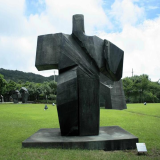

In [ ]:
cv2_imshow(train_dataset[0][0]*255)

In [ ]:
cv2_imshow(np.argmax(train_dataset[0][3],axis=-1)*255)

In [13]:
## Intializing the Dataloders

train_dataloader=Dataloder(train_dataset)
test_dataloader=Dataloder(test_dataset)

BUILDING THE MODEL ARCHITECTURE:



Creating the backbone network using the VGG16 network without fully connected layers:

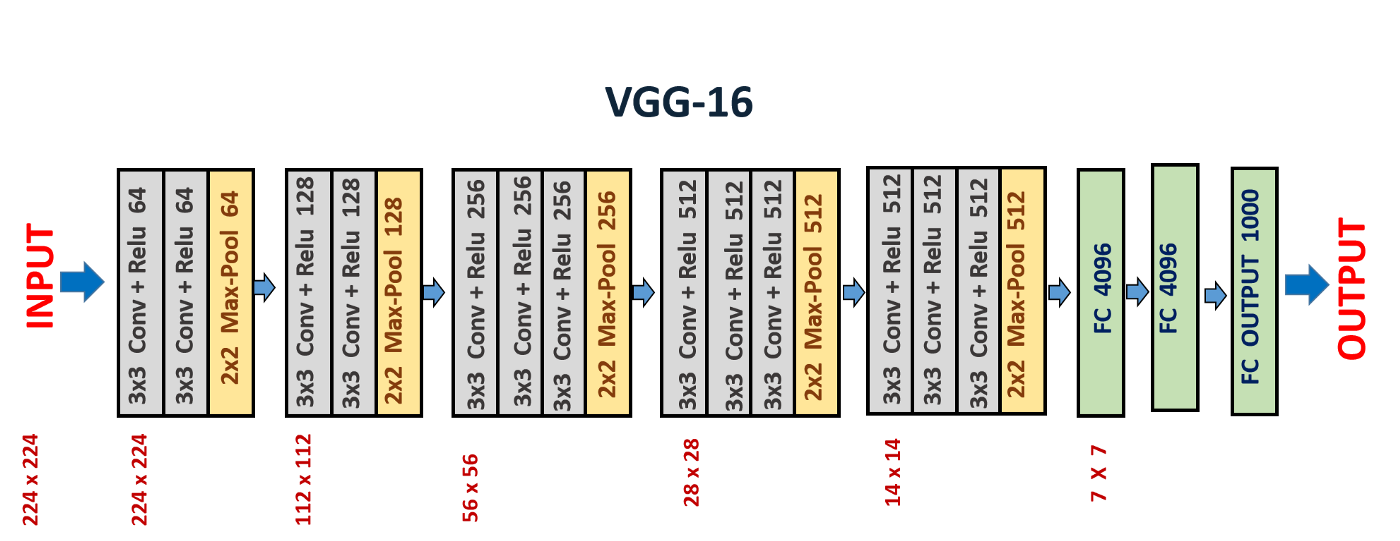



In [ ]:
## Writing the conv layer class for VGG16
## Since all the layers are convolution layers with different filters we are creating the class for this task
class vgg_conv2d(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=64, strides=1, name="conv block"):
        super().__init__(name=name)
        self.F = filters
        self.k = kernel
        self.strides = strides
        
        
    def call(self, X):
        
        #### Writing the conv2D layers

        conv_1=Conv2D(self.F,self.k,padding='same',strides=self.strides, activation='relu',kernel_initializer='glorot_uniform')(X)
        conv_2=Conv2D(self.F,self.k,padding='same', strides=self.strides,activation='relu',kernel_initializer='glorot_uniform')(conv_1)
        return conv_2

Building the side paths:

We have total 6 no of side paths in the network which are connected to 

side_path1 to conv1_2

side_path2 to conv2_2

side_path3 to conv3_3

side_path4 to conv4_3

side_path5 to conv5_3

side_path6 to pool5  of the vgg network these side path specifications are given below:

kernel_size,filters,stride,dialation_rate,padding

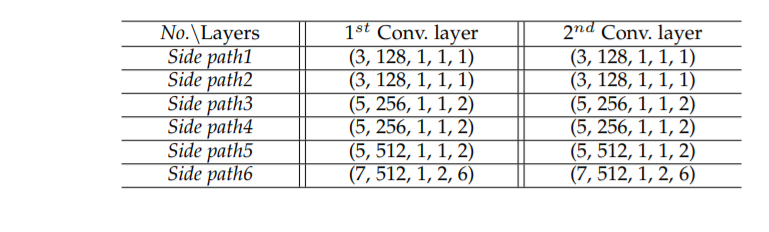

In [ ]:
## Writing the conv layer class for Side paths
## Since all the sidepaths are CNN layers with different filters we are creating this class object 

class side_path(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=128, strides=1,name="side_path"):
        super().__init__(name=name)
        self.F = filters
        self.k = kernel
        self.strides = strides
        
    def call(self, X):
        
        #### Writing the conv2D layers

        conv_1=Conv2D(self.F,self.k,padding='same', strides=self.strides,activation='relu',kernel_initializer='glorot_uniform')(X)
        conv_2=Conv2D(self.F,self.k,padding='same', strides=self.strides,activation='relu',kernel_initializer='glorot_uniform')(conv_1)
        conv_3=Conv2D(self.F,self.k,padding='same',strides=self.strides, activation='relu',kernel_initializer='glorot_uniform')(conv_2)
      
        return conv_3

Building the Cross-model fusion module:

The output from side paths fed to the Feature Compression module CP here the no of channels reduce to the k no i.e 64 in this case. The output from the CP module still has batch structure. Here in the CM module, initially we will split the batch and then conduct the element wise Addition and multiplication operations. Output from the CM module having the k channels

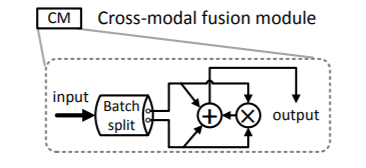

In [ ]:
## Creating the Cross‐modal fusion module

class CM_module(tf.keras.layers.Layer):
    def __init__(self,name="CM_module"):
        super().__init__(name=name)
       
    def call(self, X):
      
        RGB_batch,Depth_batch=tf.split(X,num_or_size_splits=2,axis=0)   ### Splitting the batch into two seperate batches
        Add1=Add()([RGB_batch,Depth_batch])                              
        mult1=Multiply()([RGB_batch,Depth_batch])                       ### Conducting the Addition and multiplication operations
        Add2=Add()([Add1,mult1])

        return Add2



Building the Feature Aggregation module:

Here, we Add the outputs from CM5 and CM6 and then pass this to FA5 module.later we will do upsampling of FA5 output and then add with CM4 output and then pass to FA4  like this we will do upto FA1 module. The output from FA1 pass to conv layer and compare this with the ground truth.

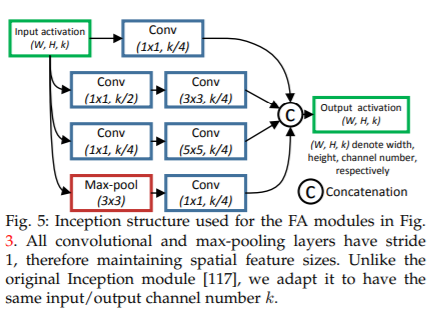


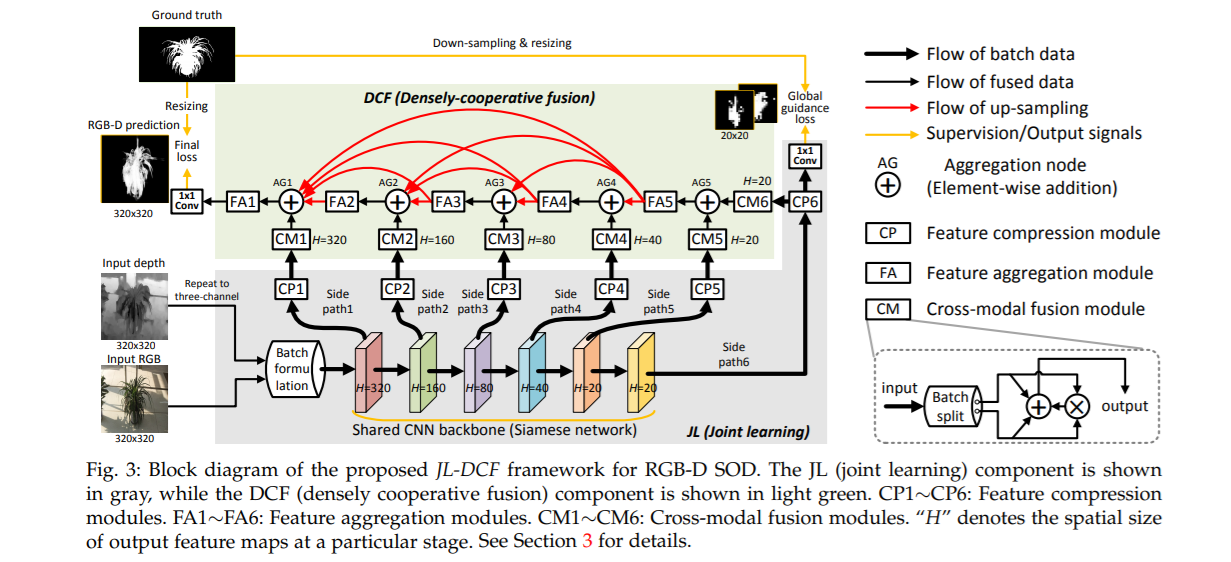

In [ ]:
#### Creating the feature Aggretion module

class FA_module(tf.keras.layers.Layer):
    def __init__(self,kernel=[1,3,5],  filters=[16,32], strides=1,name="FA_module"):
        super().__init__(name=name)
        self.F1,self.F2 = filters
        self.k1,self.k2,self.k3 = kernel
        self.strides = strides

    def call(self, X):
        
        #### Writing the conv2D layers

        conv_1=Conv2D(self.F1,self.k1,padding='same', strides=self.strides,activation='relu',kernel_initializer='glorot_uniform')(X)

        conv_2_1=Conv2D(self.F2,self.k1,padding='same',strides=self.strides, activation='relu',kernel_initializer='glorot_uniform')(X)
        conv_2_2=Conv2D(self.F1,self.k2,padding='same',strides=self.strides,activation='relu',kernel_initializer='glorot_uniform')(conv_2_1)

        conv_3_1=Conv2D(self.F1,self.k1,padding='same',strides=self.strides,activation='relu',kernel_initializer='glorot_uniform')(X)
        conv_3_2=Conv2D(self.F1,self.k3,padding='same',strides=self.strides,activation='relu',kernel_initializer='glorot_uniform')(conv_3_1)

        pool_4=MaxPool2D(pool_size=(3,3),strides=1,padding='same')(X)
        conv_4=Conv2D(self.F1,self.k1,padding='same',strides=self.strides,activation='relu',kernel_initializer='glorot_uniform')(pool_4)
        

        FA=concatenate([conv_1,conv_2_2,conv_3_2,conv_4],axis=-1)  ## Concatenating the all outputs fron all the layers
        FA=Conv2D(64,1,padding='same',strides=self.strides,activation='relu',kernel_initializer='glorot_uniform')(FA)
        FA=tf.keras.layers.Dropout(0.3)(FA)
        return FA

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_image (InputLayer)          [(1, 160, 160, 3)]   0                                            
__________________________________________________________________________________________________
Depth_image (InputLayer)        [(1, 160, 160, 3)]   0                                            
__________________________________________________________________________________________________
tf_op_layer_stack_5 (TensorFlow [(2, 1, 160, 160, 3) 0           RGB_image[0][0]                  
                                                                 Depth_image[0][0]                
__________________________________________________________________________________________________
tf_op_layer_Reshape_5 (TensorFl [(2, 160, 160, 3)]   0           tf_op_layer_stack_5[0][0]  

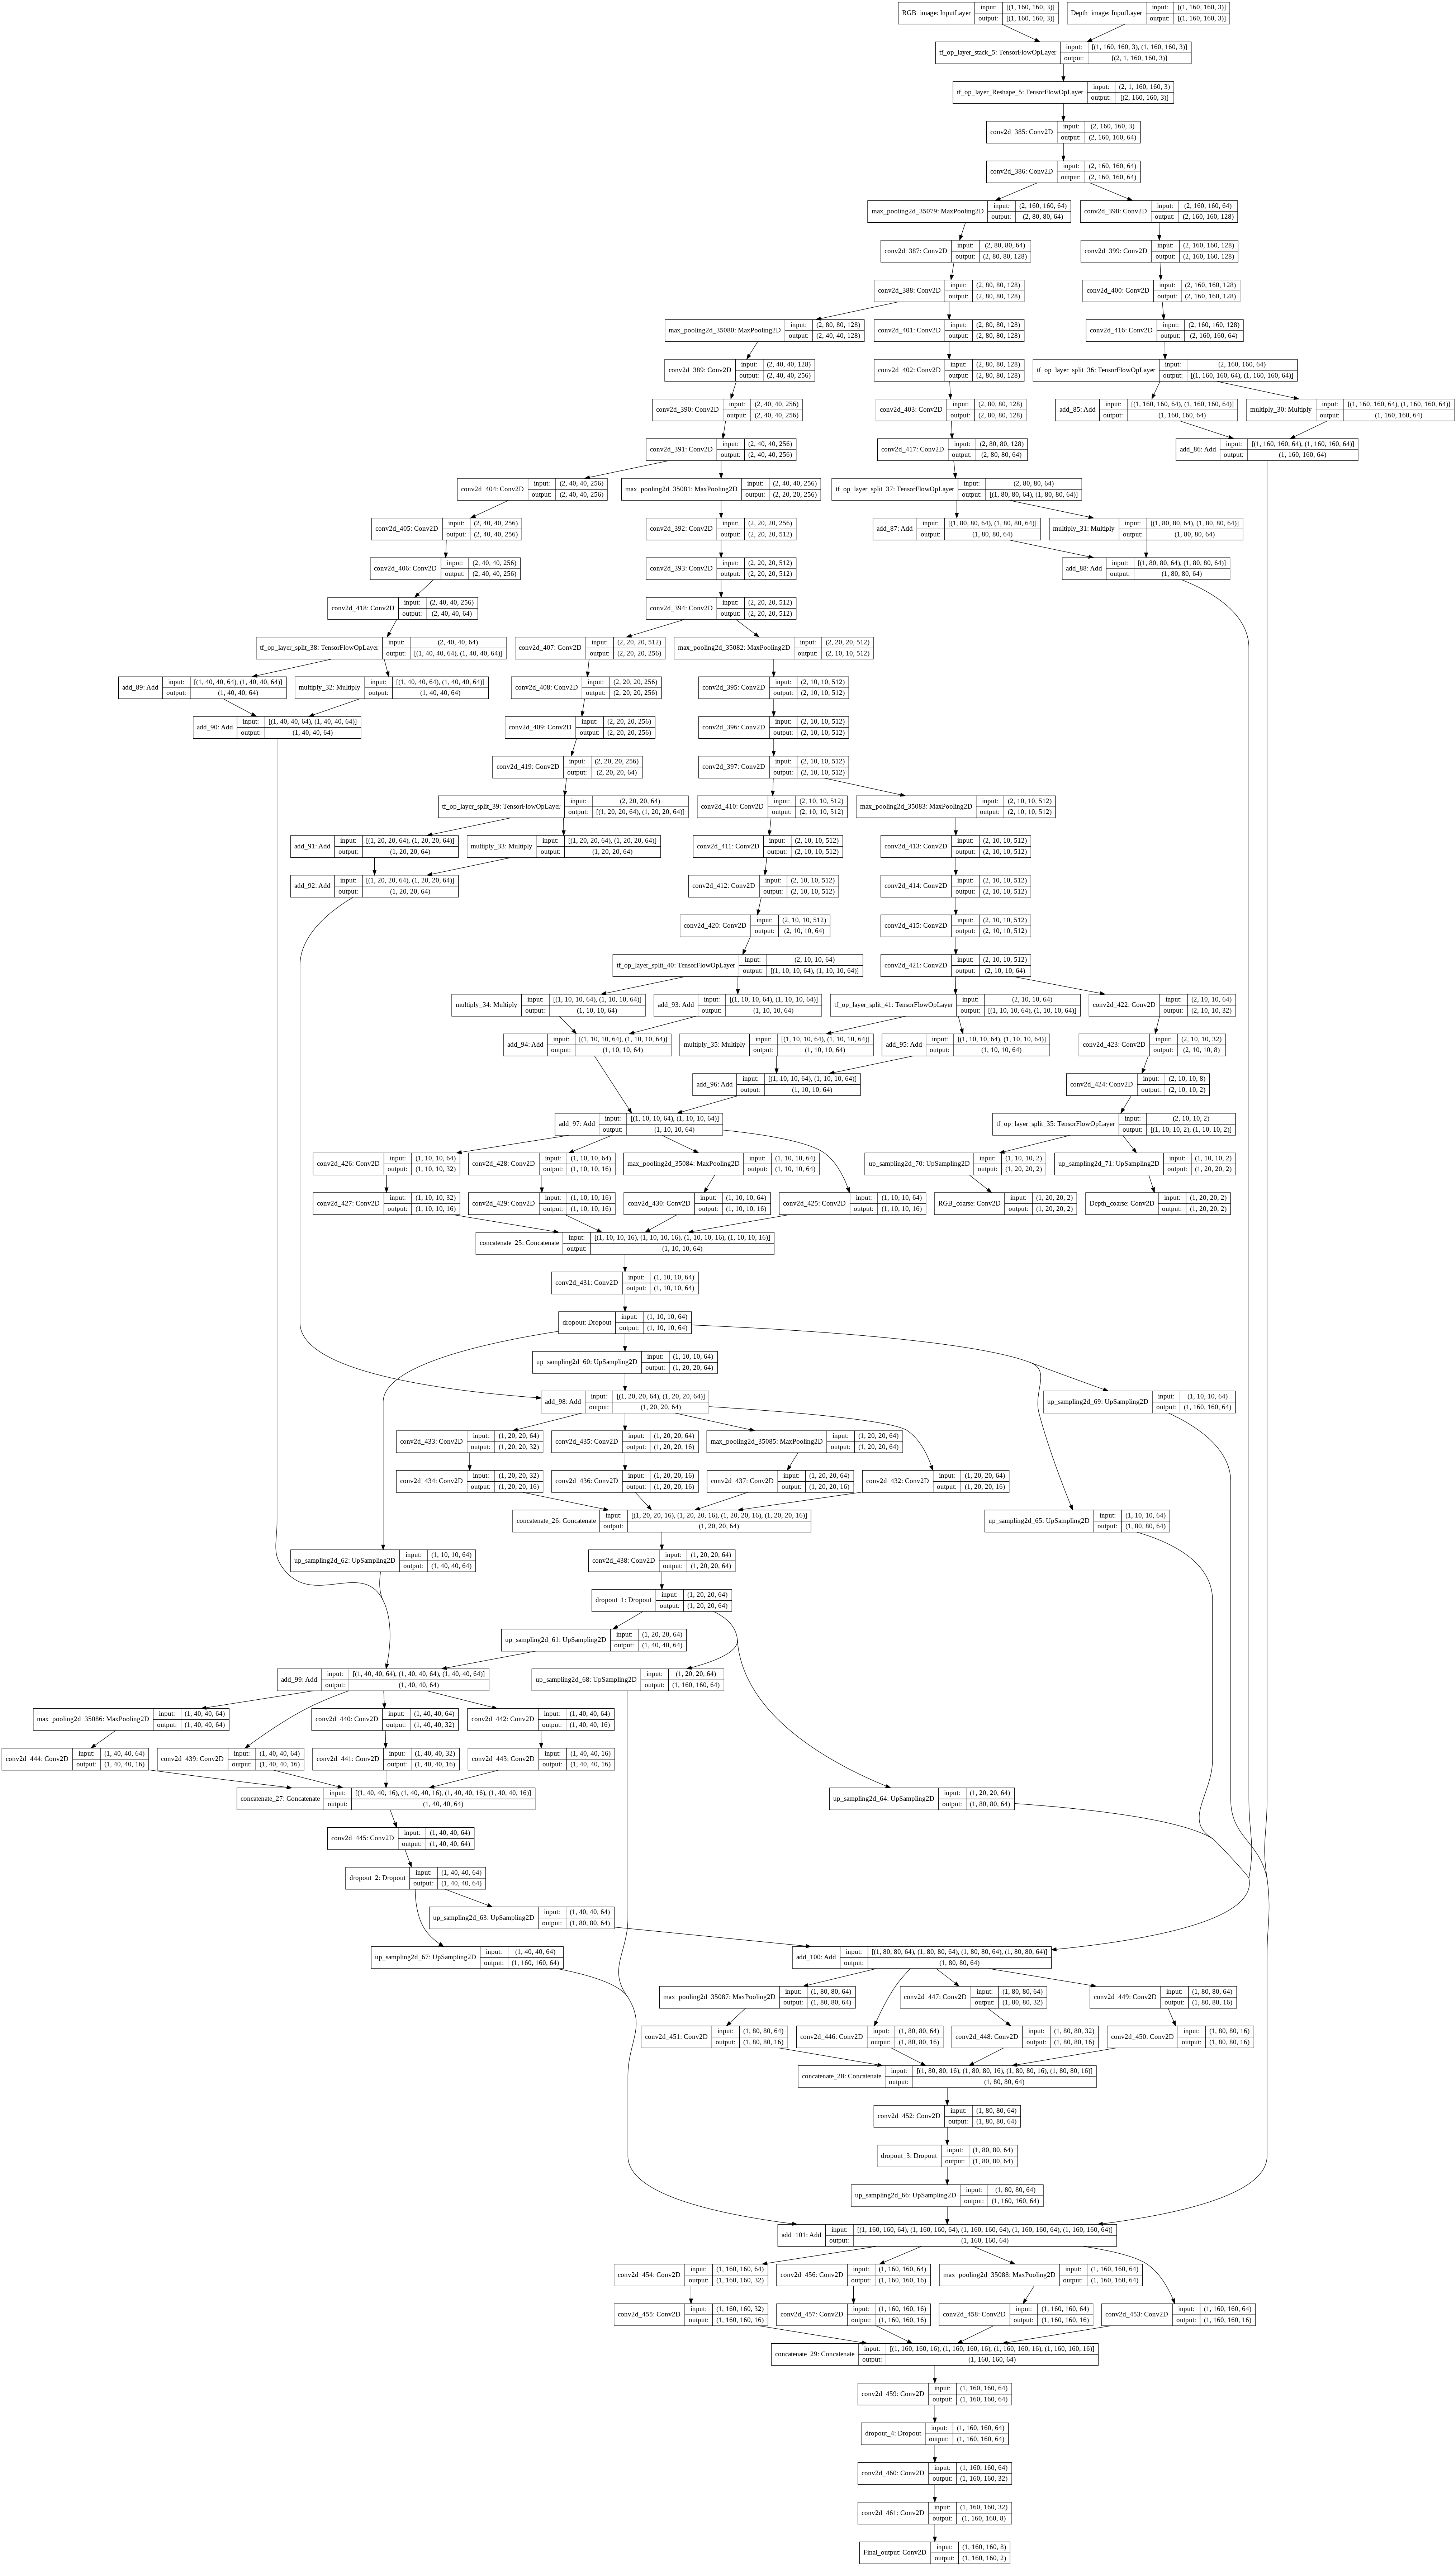

In [ ]:
### Building the model Architecture

RGB_input=Input(shape=(160,160,3), batch_size=1,name='RGB_image')          ### Two different inputs of RGB and Depth images
Depth_input=Input(shape=(160,160,3), batch_size=1,name='Depth_image')

input=tf.stack([RGB_input,Depth_input],axis=0)
input=tf.reshape(input,[2,160,160,3])                     ### Adding in batch direction

#### Building VGG16 Network

conv_1_2=vgg_conv2d().call(input)
pool_1=MaxPool2D(pool_size=(2,2),strides=(2,2))(conv_1_2)

conv_2_2=vgg_conv2d(filters=128).call(pool_1)
pool_2=MaxPool2D(pool_size=(2,2),strides=(2,2))(conv_2_2)

conv_3_2=vgg_conv2d(filters=256).call(pool_2)
conv_3_3=Conv2D(256,(3,3),strides=1,padding='same',activation='relu',kernel_initializer='glorot_uniform')(conv_3_2)
pool_3=MaxPool2D(pool_size=(2,2),strides=(2,2))(conv_3_3)

conv_4_2=vgg_conv2d(filters=512).call(pool_3)
conv_4_3=Conv2D(512,(3,3),strides=1,padding='same',activation='relu',kernel_initializer='glorot_uniform')(conv_4_2)
pool_4=MaxPool2D(pool_size=(2,2),strides=(2,2))(conv_4_3)


conv_5_2=vgg_conv2d(filters=512).call(pool_4)
conv_5_3=Conv2D(512,(3,3),strides=1,padding='same',activation='relu',kernel_initializer='glorot_uniform')(conv_5_2)

pool_5=MaxPool2D(pool_size=(2,2),strides=1,padding='same')(conv_5_3)

### Connecting the VGG16 with side paths

side_path_1=side_path().call(conv_1_2)

side_path_2=side_path().call(conv_2_2)

side_path_3=side_path(kernel=5,filters=256).call(conv_3_3)

side_path_4=side_path(kernel=5,filters=256).call(conv_4_3)

side_path_5=side_path(kernel=5,filters=512).call(conv_5_3)

side_path_6_1=Conv2D(512,7,strides=1,dilation_rate=2,padding='same',activation='relu',kernel_initializer='glorot_uniform')(pool_5)
side_path_6=Conv2D(512,7,strides=1,dilation_rate=2,padding='same',activation='relu',kernel_initializer='glorot_uniform')(side_path_6_1)
side_path_6=Conv2D(512,7,strides=1,dilation_rate=2,padding='same',activation='relu',kernel_initializer='glorot_uniform')(side_path_6)
### Connecting the side_paths to Feature Compression modules (CP)

cp_1=Conv2D(64,3,padding='same',activation='relu',kernel_initializer='glorot_uniform')(side_path_1)  ## Passing the output of side path to CP module

cp_2=Conv2D(64,3,padding='same',activation='relu',kernel_initializer='glorot_uniform')(side_path_2)

cp_3=Conv2D(64,3,padding='same',activation='relu',kernel_initializer='glorot_uniform')(side_path_3)

cp_4=Conv2D(64,3,padding='same',activation='relu',kernel_initializer='glorot_uniform')(side_path_4)

cp_5=Conv2D(64,3,padding='same',activation='relu',kernel_initializer='glorot_uniform')(side_path_5)

cp_6=Conv2D(64,3,padding='same',activation='relu',kernel_initializer='glorot_uniform')(side_path_6)

cp_6_out=Conv2D(32,1,padding='same',activation='relu',kernel_initializer='glorot_uniform')(cp_6)
cp_6_out=Conv2D(8,1,padding='same',activation='relu',kernel_initializer='glorot_uniform')(cp_6_out)
cp_6_out=Conv2D(2,1,padding='same',activation='relu',kernel_initializer='glorot_uniform')(cp_6_out)

global_1,global_2=tf.split(cp_6_out,num_or_size_splits=2,axis=0)  ## Splitting the output of CP6 module into Depth and RGB outputs

### Connecting the CP modules to CM modules

cm1=CM_module().call(cp_1)           ### Passing the CP output to CM module

cm2=CM_module().call(cp_2)

cm3=CM_module().call(cp_3)

cm4=CM_module().call(cp_4)

cm5=CM_module().call(cp_5)

cm6=CM_module().call(cp_6)

### Adding the Feature Aggregation Modules FA

AG5=Add()([cm5,cm6])                                       ### Adding the outputs of CM5 and CM6 modules

FA5=FA_module().call(AG5)                                    ### Passing the Aggregation5 output to FA5 module

FA5_up_1=UpSampling2D((2,2),interpolation='bilinear')(FA5)   ### Upsampling the FA5 output

AG4=Add()([FA5_up_1,cm4])                                    ### Adding the upsampled output of FA modules to CM4 module output

FA4=FA_module().call(AG4)                                     ### Passing the Aggregation4 output to FA4 module

FA4_up_1=UpSampling2D((2,2),interpolation='bilinear')(FA4)   ### Upsampling the FA5 and FA4 output
FA5_up_2=UpSampling2D((4,4),interpolation='bilinear')(FA5)

AG3=Add()([FA4_up_1,FA5_up_2,cm3])                           ### Adding all the upsampled outputs of FA modules to CM3 module output

FA3=FA_module().call(AG3)                                     ### Passing the Aggregation3 output to FA3 module

FA3_up_1=UpSampling2D((2,2),interpolation='bilinear')(FA3)   ### Upsampling the FA5,FA4 and FA3 output
FA4_up_2=UpSampling2D((4,4),interpolation='bilinear')(FA4)
FA5_up_3=UpSampling2D((8,8),interpolation='bilinear')(FA5)

AG2=Add()([FA3_up_1,FA4_up_2,FA5_up_3,cm2])                     ### Adding all the upsampled outputs of FA modules to CM2 module output

FA2=FA_module().call(AG2)                                      ### Passing the Aggregation2 output to FA2 module

FA2_up_1=UpSampling2D((2,2),interpolation='bilinear')(FA2)    ### Upsampling the FA5,FA4,FA3 and FA2 output
FA3_up_2=UpSampling2D((4,4),interpolation='bilinear')(FA3)
FA4_up_3=UpSampling2D((8,8),interpolation='bilinear')(FA4)
FA5_up_4=UpSampling2D((16,16),interpolation='bilinear')(FA5)

AG1=Add()([FA2_up_1,FA3_up_2,FA4_up_3,FA5_up_4,cm1])          ### Adding all the upsampled outputs of FA modules to CM1 module output

FA1=FA_module().call(AG1)                                      ### Passing the Aggregation1 output to FA1 module

                                                             ### Passing the output from FA1 module to Final Conv2D layer, here we are creating the 2 channels as the GT having 2 channels

FA1_out=Conv2D(32,1,padding='same',activation='relu',kernel_initializer='glorot_uniform')(FA1)
FA1_out=Conv2D(8,1,padding='same',activation='relu',kernel_initializer='glorot_uniform')(FA1_out)
Final_output=Conv2D(2,1,padding='same',name='Final_output',activation='softmax',kernel_initializer='glorot_uniform')(FA1_out)

global_RGB=UpSampling2D((2,2),interpolation='bilinear')(global_1)   ### Passing the output from CP6 module to Final Conv2D layer, here we are creating the 2 channels as the GT having 2 channels
global_RGB=Conv2D(2,1,activation='softmax',padding='same',name='RGB_coarse',kernel_initializer='glorot_uniform')(global_RGB)
global_Depth=UpSampling2D((2,2),interpolation='bilinear')(global_2)
global_Depth=Conv2D(2,1,activation='softmax',padding='same',name='Depth_coarse',kernel_initializer='glorot_uniform')(global_Depth)
                                                                   ### Passing the output from CP6 module to Final Conv2D layer, here we are creating the 2 channels as the GT having 2 channels

      ## Intiating the Model with two inputs and three outputs
model=Model(inputs=[RGB_input,Depth_input],outputs=[global_RGB,global_Depth,Final_output])


model.summary()


tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,      ## Plotting the model
    rankdir='TB')

In [14]:
### This code was taken from this link https://github.com/tensorflow/tensorflow/issues/37876#issuecomment-760064536
## It avoids the call backs are slow than batch updates type warnings

from tensorflow.python.keras.callbacks import CallbackList
class CustomCallbackList(CallbackList):
    def _call_batch_hook(self, mode, hook, batch, logs=None):
        """Helper function for all batch_{begin | end} methods."""
        if not self.callbacks:
            return
        hook_name = 'on_{mode}_batch_{hook}'.format(mode=mode, hook=hook)

        logs = logs or {}
        for callback in self.callbacks:
            batch_hook = getattr(callback, hook_name)
            batch_hook(batch, logs)

tf.python.keras.callbacks.CallbackList = CustomCallbackList


In [15]:
### Here, we are dividing the image into blocks for S_score calculation

def divide_image(image):
    
    length=image.shape[0]
    L=int(length/2)
    h1=image[:L]         ### Diving the image into two parts
    h2=image[L:]

    image1=[]
    image2=[]
    image3=[]
    image4=[]
    length2=len(h1[0])
    L=int(length2/2)
    for i in range(L):      ## Dividing the above two images into two another parts
      w1=h1[i][:L]
      w2=h1[i][L:]
      w3=h2[i][:L]
      w4=h2[i][L:]

      image1.append(w1)
      image2.append(w2)
      image3.append(w3)
      image4.append(w4)

    return np.array(image1),np.array(image2),np.array(image3),np.array(image4)

In [16]:
## Calculating the S_score https://openaccess.thecvf.com/content_ICCV_2017/papers/Fan_Structure-Measure_A_New_ICCV_2017_paper.pdf

def S_score(actual_image,pred_image,pred_image_,actual_image_):
    
    w=actual_image.shape[1]
    h=actual_image.shape[2]

    images_4_gt=[i for i in divide_image(np.reshape(actual_image,(w,h)))]
    images_4_pred=[i for i in divide_image(np.reshape(pred_image,(w,h)))]
    
    W=np.sum(np.reshape(actual_image,(w,h)))
    
    ssim=[]

    for i in range(len(images_4_gt)):

      images_gt=divide_image(images_4_gt[i])     ## Here we divide the whole image into 16 parts

      images_pred=divide_image(images_4_pred[i])
  
      for j in range(len(images_gt)):
        ### Calculating the luminance comparision of image (2*x*y/x**2+y**2) here x and y are the means of predicted and ground truth images

        ssm=(2*np.mean(images_gt[j])*np.mean(images_pred[j]))/((np.mean(images_gt[j]))**2+(np.mean(images_pred[j]))**2+0.0001)
      
        ### Calculating the contrast comparision of image (2*x*y/x**2+y**2) here x and y are the variance of predicted and ground truth images

        ssd=(2*np.std(images_gt[j])*np.std(images_pred[j]))/((np.std(images_gt[j]))**2+(np.std(images_pred[j]))**2+0.0001)
      
        ### Calculating the structure comparision of image (c/x**2+y**2) here x and y are the variance of predicted and ground truth images and c is the covariance of the two images
        ssc=np.sum(((images_gt[j]-np.mean(images_gt[j]))*(images_pred[j]-np.mean(images_pred[j])))/((np.std(images_gt[j]))*(np.std(images_pred[j]))+0.0001))/(40*40-1)
  
        w_k=(np.sum(images_gt[j]))/W   ## Calculating the weights
        
        ssir=w_k*ssm*ssd*ssc  ###  calculating the region-aware structural similarity measure 
        
        ssim.append(ssir)
        
    S_r=sum(ssim)   ### calculating the region-aware structural similarity measure 

    ### calculating the object-aware structural similarity measure 
    pred_image_reshape=np.reshape(pred_image_,(w,h,2))

    pred_image_FG=pred_image_reshape[:,:,0]  ## Dividing the predicted  image into foreground and background images

    pred_image_BG=pred_image_reshape[:,:,1]

    OFG=(2*np.mean(pred_image_FG))/((np.mean(pred_image_FG))**2+1+2*0.25*np.std(pred_image_FG))  ## Calculating the similarity at object levels
  
    BFG=(2*np.mean(pred_image_BG))/((np.mean(pred_image_BG))**2+1+2*0.25*np.std(pred_image_BG))
    
    actual_image_=np.reshape(actual_image_,(w,h,2))

    m_u=np.mean(actual_image_[:,:,1])

    S_o=m_u*OFG+(1-m_u)*BFG

    S_score=S_r*0.5+S_o*0.5   ## Calculating the S_score
  
    return S_score

In [17]:
### Calculating the E_score  https://www.ijcai.org/proceedings/2018/0097.pdf

def E_score(actual_image,pred_image):

    w=actual_image.shape[1]
    h=actual_image.shape[2]
    
    pred_image=np.reshape(pred_image,(w,h))

    actual_image=np.reshape(actual_image,(w,h))

    bias_pred=pred_image-np.ones((w,h))*np.mean(pred_image)  ### Calculating the bias matrix of predicted image

    bias_gt=actual_image-np.ones((w,h))*np.mean(actual_image)   ### Calculating the bias matrix of ground truth image

    FM=(2*bias_pred*bias_gt)/((bias_gt*bias_gt)+(bias_pred*bias_pred))  ### Calculating the alighnment matrix of ground truth image

    f=((1+FM)**2)/(4)  ## Calculating the enhanced alignment matrix 

    E=np.sum(f)/(w*h)    ### Calculating the E_score
    
    return E

In [18]:
## Calculating the Metrics

class Loss_History(tf.keras.callbacks.Callback):
  def __init__(self,validation_data=test_dataloader):
    super(Loss_History,self).__init__()
    self.validation_data=validation_data
    self.history={'precision':[],'recall':[],'F_beta_score':[],'S_score':[],'E_score':[],'MAE':[]}
  
  
  def on_test_batch_end(self,batch,logs={}):

    r,d,pred_image_=self.model.predict(test_dataloader[batch][0])  ## Predicting the final output image

    pred_image=np.argmax(pred_image_,axis=-1)    ## Sorting the channel wise of image

    actual_image_=test_dataloader[batch][1][2]  ## Ground truth

    actual_image=np.argmax(actual_image_,axis=-1)
   
    w=actual_image.shape[1]
    h=actual_image.shape[2]

    precision=precision_score(np.reshape(actual_image,(w,h)),np.reshape(pred_image,(w,h)),average='micro')  ## Finding the precision and recall

    recall=recall_score(np.reshape(actual_image,(w,h)),np.reshape(pred_image,(w,h)),average='micro')

    mae=mean_absolute_error(np.reshape(actual_image,(w,h)),np.reshape(pred_image,(w,h)))      ## Finding the mean absolute error

    F_b_score=(1.3*precision*recall)/(0.3*precision+recall+0.00001)    ## Finding the F_beta_score

    s_score=S_score(actual_image,pred_image,pred_image_,actual_image_)  ## Finding the S_score and E_score
    
    e_score=E_score(actual_image,pred_image)

    self.history['precision'].append(precision)

    self.history['recall'].append(recall)

    self.history['F_beta_score'].append(F_b_score)

    self.history['S_score'].append(s_score)

    self.history['E_score'].append(e_score)

    self.history['MAE'].append(mae)
    
  def on_epoch_end(self,epoch,logs={}):
    
    
    precision_score=np.mean(np.array(self.history['precision']))

    recall_score=np.mean(np.array(self.history['recall']))

    F_score=np.mean(np.array(self.history['F_beta_score']))

    s_score=np.mean(np.array(self.history['S_score']))
    
    e_score=np.mean(np.array(self.history['E_score']))

    mae_score=np.mean(np.array(self.history['MAE']))

    print('precision_score:%f,recall_score:%f,F_beta_score:%f,S_score:%f,E_score:%f,MAE:%f'%(precision_score,recall_score,F_score,s_score,e_score,mae_score))


    return

history_own=Loss_History()


In [2]:
%load_ext tensorboard

In [ ]:
### Compiling the model

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss={ 'RGB_coarse':tf.keras.losses.BinaryCrossentropy(),  ## As we converted all the images to binary we are using the binary cross entropy
          'Depth_coarse':tf.keras.losses.BinaryCrossentropy(),  ## These two are for coarse outputs of VGG16
          "Final_output":tf.keras.losses.BinaryCrossentropy()  ## This loss we obtained at final output
         } )

In [21]:
log_dir="/content/drive/MyDrive/best_model_CS2_modified_/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensor_board = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)


lr_plateu=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, mode='min', min_delta=0.001,  min_lr=0.000001)
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, mode='min',restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/best_model_CS2_modified_.h5', save_weights_only=False, save_best_only=True, mode='min', monitor='val_loss')

In [ ]:

history=model.fit(train_dataloader,validation_data=test_dataloader,epochs=35,callbacks=[checkpoint,history_own,tensor_board,lr_plateu,early_stop],workers=-1)  ## Fitting the model with the call backs and epochs

Epoch 1/35
1588/1588 [==============================] - 493s 310ms/step - loss: 1.7126 - RGB_coarse_loss: 0.6088 - Depth_coarse_loss: 0.6907 - Final_output_loss: 0.4131 - val_loss: 1.5957 - val_RGB_coarse_loss: 0.5524 - val_Depth_coarse_loss: 0.6810 - val_Final_output_loss: 0.3623 - lr: 1.0000e-04
Epoch 2/35
1588/1588 [==============================] - 490s 309ms/step - loss: 1.5066 - RGB_coarse_loss: 0.5162 - Depth_coarse_loss: 0.6248 - Final_output_loss: 0.3655 - val_loss: 1.4397 - val_RGB_coarse_loss: 0.4904 - val_Depth_coarse_loss: 0.5924 - val_Final_output_loss: 0.3568 - lr: 1.0000e-04
Epoch 3/35
1588/1588 [==============================] - 491s 309ms/step - loss: 1.3765 - RGB_coarse_loss: 0.4843 - Depth_coarse_loss: 0.5683 - Final_output_loss: 0.3239 - val_loss: 1.2774 - val_RGB_coarse_loss: 0.4758 - val_Depth_coarse_loss: 0.5231 - val_Final_output_loss: 0.2784 - lr: 1.0000e-04
Epoch 4/35
1588/1588 [==============================] - 491s 309ms/step - loss: 1.2710 - RGB_coarse_los

In [19]:
model=load_model('/content/drive/MyDrive/best_model_CS2_modified_.h5')

In [22]:
history=model.fit(train_dataloader,validation_data=test_dataloader,epochs=35,initial_epoch=7,callbacks=[checkpoint,history_own,tensor_board,lr_plateu,early_stop],workers=-1)  ## Fitting the model with the call backs and epochs

Epoch 8/35
1588/1588 [==============================] - 483s 304ms/step - loss: 0.9970 - RGB_coarse_loss: 0.4133 - Depth_coarse_loss: 0.3735 - Final_output_loss: 0.2102 - val_loss: 1.0353 - val_RGB_coarse_loss: 0.4321 - val_Depth_coarse_loss: 0.3816 - val_Final_output_loss: 0.2216 - lr: 1.0000e-04
Epoch 9/35
1588/1588 [==============================] - 495s 312ms/step - loss: 0.9340 - RGB_coarse_loss: 0.3933 - Depth_coarse_loss: 0.3474 - Final_output_loss: 0.1932 - val_loss: 0.9972 - val_RGB_coarse_loss: 0.4289 - val_Depth_coarse_loss: 0.3541 - val_Final_output_loss: 0.2142 - lr: 1.0000e-04
Epoch 10/35
1588/1588 [==============================] - 494s 311ms/step - loss: 0.8886 - RGB_coarse_loss: 0.3769 - Depth_coarse_loss: 0.3299 - Final_output_loss: 0.1818 - val_loss: 0.9522 - val_RGB_coarse_loss: 0.4097 - val_Depth_coarse_loss: 0.3450 - val_Final_output_loss: 0.1975 - lr: 1.0000e-04
Epoch 11/35
1588/1588 [==============================] - 489s 308ms/step - loss: 0.8192 - RGB_coarse_l

In [23]:
history=model.fit(train_dataloader,validation_data=test_dataloader,epochs=35,initial_epoch=16,callbacks=[checkpoint,history_own,tensor_board,lr_plateu,early_stop],workers=-1)  ## Fitting the model with the call backs and epochs

Epoch 17/35
1588/1588 [==============================] - 487s 307ms/step - loss: 0.6864 - RGB_coarse_loss: 0.2959 - Depth_coarse_loss: 0.2678 - Final_output_loss: 0.1226 - val_loss: 0.9286 - val_RGB_coarse_loss: 0.4197 - val_Depth_coarse_loss: 0.3226 - val_Final_output_loss: 0.1863 - lr: 1.0000e-05
Epoch 18/35
1588/1588 [==============================] - 471s 297ms/step - loss: 0.6454 - RGB_coarse_loss: 0.2762 - Depth_coarse_loss: 0.2575 - Final_output_loss: 0.1118 - val_loss: 0.9493 - val_RGB_coarse_loss: 0.4335 - val_Depth_coarse_loss: 0.3220 - val_Final_output_loss: 0.1938 - lr: 1.0000e-05
Epoch 19/35
1588/1588 [==============================] - 471s 297ms/step - loss: 0.6181 - RGB_coarse_loss: 0.2618 - Depth_coarse_loss: 0.2505 - Final_output_loss: 0.1057 - val_loss: 0.9566 - val_RGB_coarse_loss: 0.4374 - val_Depth_coarse_loss: 0.3218 - val_Final_output_loss: 0.1974 - lr: 1.0000e-05
Epoch 20/35
1588/1588 [==============================] - 471s 297ms/step - loss: 0.5908 - RGB_coarse

In [25]:
history=model.fit(train_dataloader,validation_data=test_dataloader,epochs=35,initial_epoch=22,callbacks=[checkpoint,history_own,tensor_board,lr_plateu,early_stop],workers=-1)  ## Fitting the model with the call backs and epochs

Epoch 23/35
1588/1588 [==============================] - 471s 297ms/step - loss: 0.6461 - RGB_coarse_loss: 0.2769 - Depth_coarse_loss: 0.2572 - Final_output_loss: 0.1120 - val_loss: 0.9371 - val_RGB_coarse_loss: 0.4245 - val_Depth_coarse_loss: 0.3228 - val_Final_output_loss: 0.1898 - lr: 1.0000e-06
Epoch 24/35
1588/1588 [==============================] - 471s 297ms/step - loss: 0.6412 - RGB_coarse_loss: 0.2743 - Depth_coarse_loss: 0.2560 - Final_output_loss: 0.1108 - val_loss: 0.9413 - val_RGB_coarse_loss: 0.4272 - val_Depth_coarse_loss: 0.3230 - val_Final_output_loss: 0.1911 - lr: 1.0000e-06
Epoch 25/35
1588/1588 [==============================] - 470s 296ms/step - loss: 0.6372 - RGB_coarse_loss: 0.2724 - Depth_coarse_loss: 0.2551 - Final_output_loss: 0.1098 - val_loss: 0.9434 - val_RGB_coarse_loss: 0.4289 - val_Depth_coarse_loss: 0.3229 - val_Final_output_loss: 0.1916 - lr: 1.0000e-06
Epoch 26/35
1588/1588 [==============================] - 470s 296ms/step - loss: 0.6335 - RGB_coarse

In [26]:
%tensorboard --logdir /content/drive/MyDrive/best_model_CS2_modified_/logs/fit

<IPython.core.display.Javascript object>

In [30]:
model2=load_model('/content/drive/MyDrive/best_model_CS2_modified.h5')

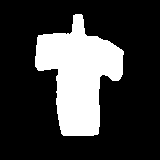

In [31]:
rgb,depth,final=model2.predict(train_dataloader[0][0])

final=np.argmax(final,axis=-1)

final=final*255
cv2_imshow(np.reshape(final,(160,160)))

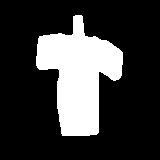

In [28]:
cv2_imshow(np.argmax(train_dataset[0][2],axis=-1)*255)

E_score: 0.8298143321987408


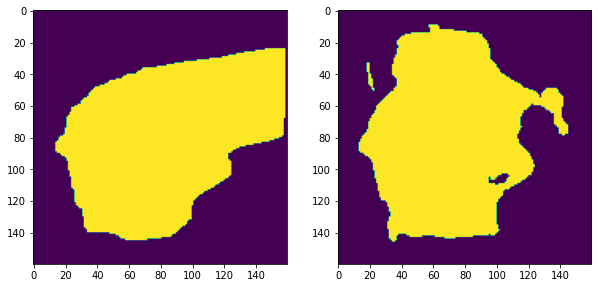

E_score: 0.9743664838217865


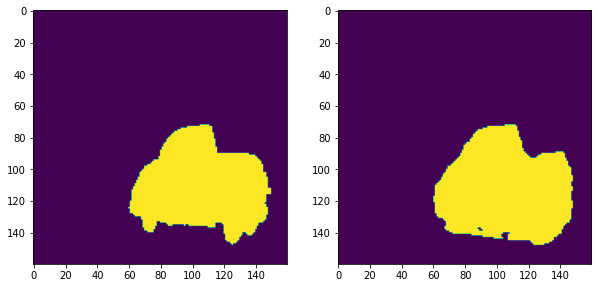

E_score: 0.9354368352930197


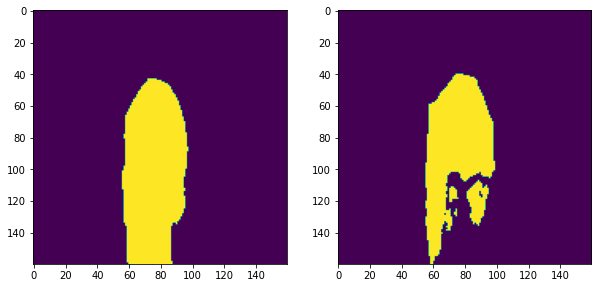

E_score: 0.9880252347961467


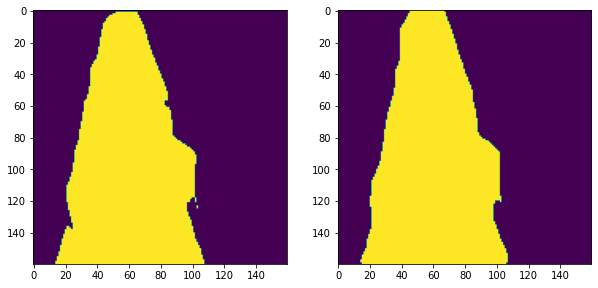

E_score: 0.41677774250140487


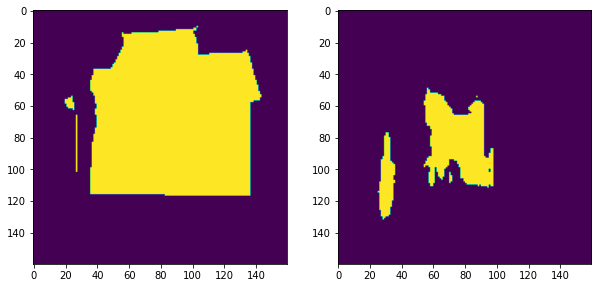

E_score: 0.9764363998841621


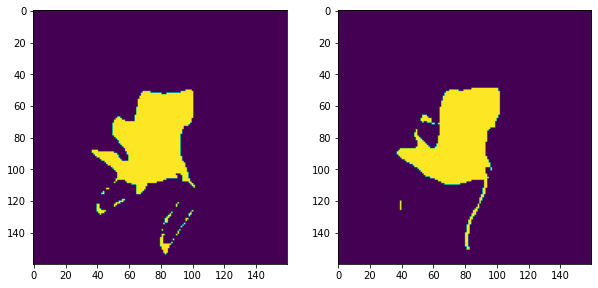

E_score: 0.9145740843092193


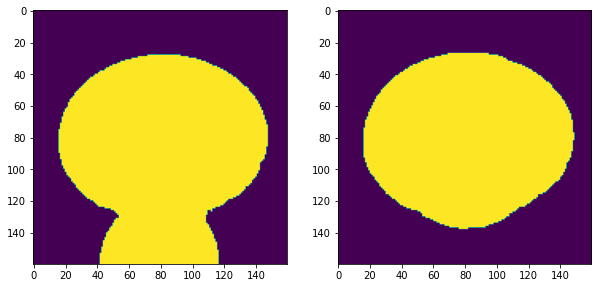

E_score: 0.9889653967903924


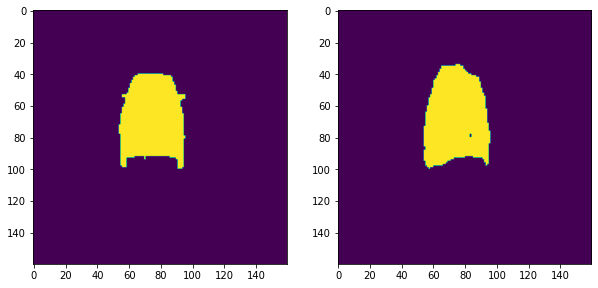

E_score: 0.6987664729418337


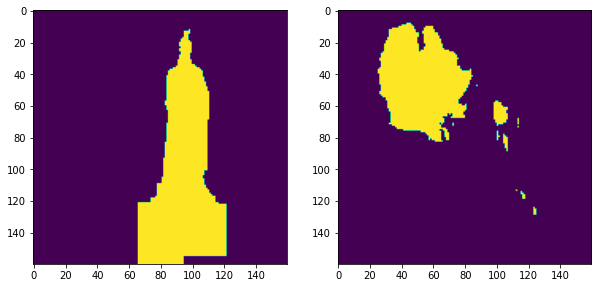

E_score: 0.9794713729579199


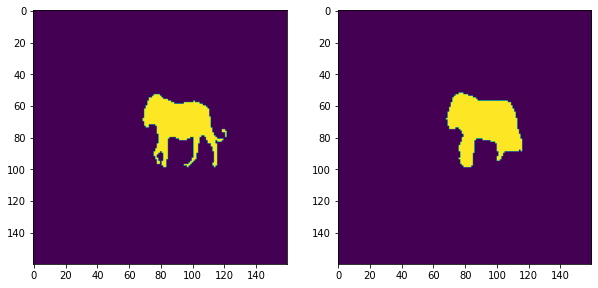

E_score: 0.8021507267404497


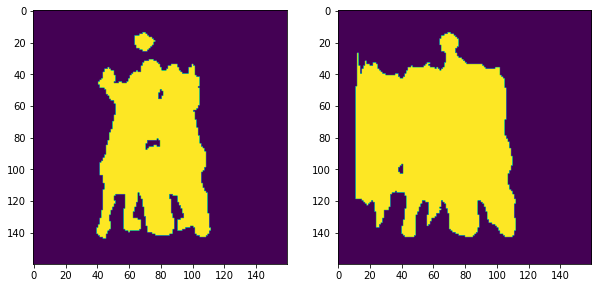

E_score: 0.9912544859474943


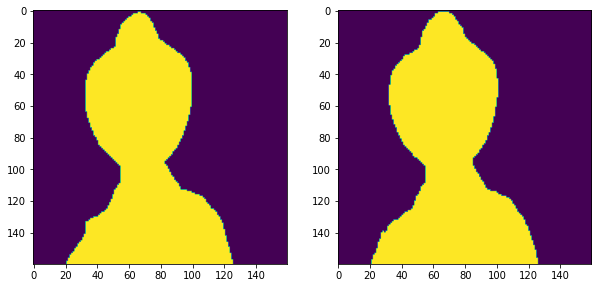

E_score: 0.8713763557356965


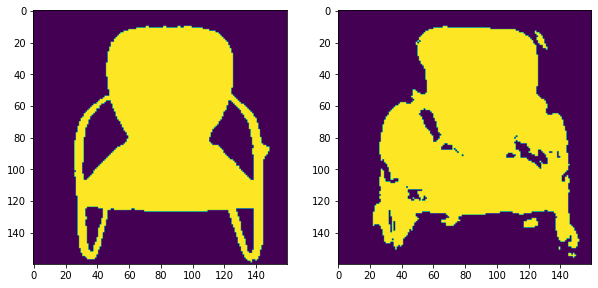

E_score: 0.8702749538746585


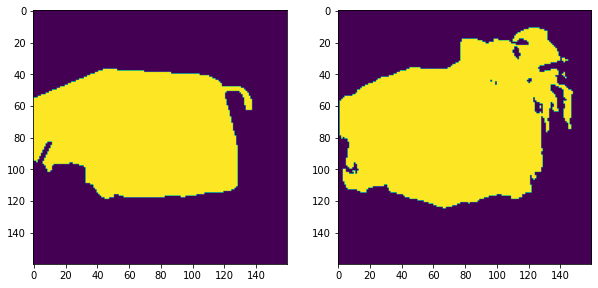

E_score: 0.9636118582939294


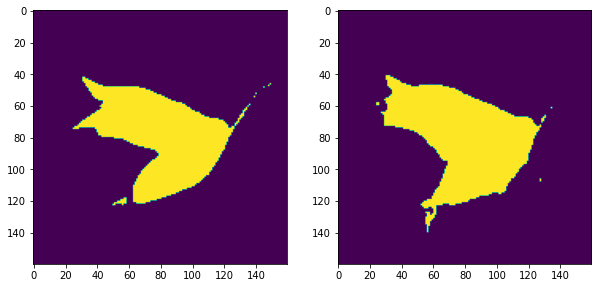

E_score: 0.9606897191910035


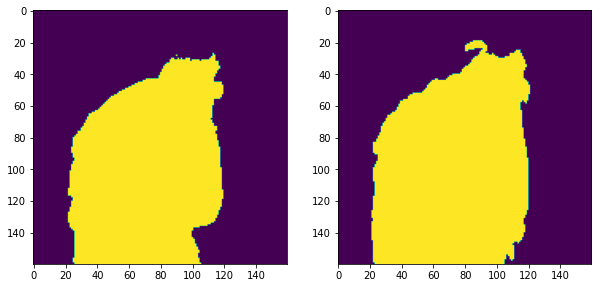

E_score: 0.9776760094968353


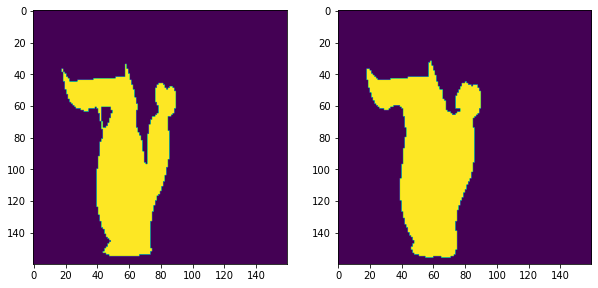

E_score: 0.9750293962485853


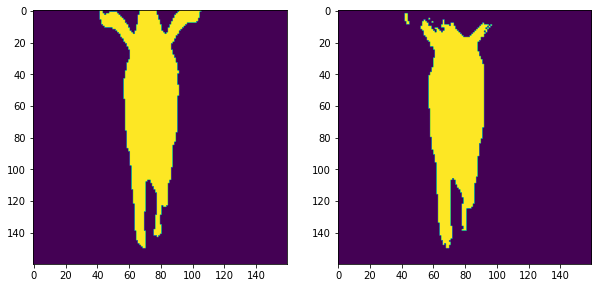

E_score: 0.909054649218


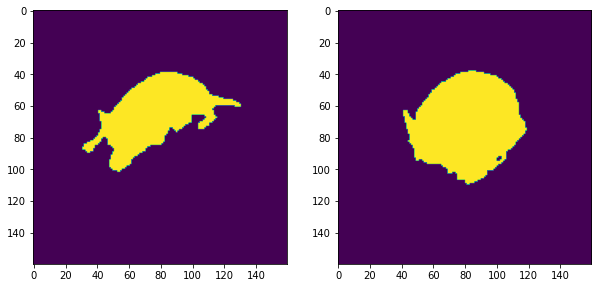

E_score: 0.979239985896988


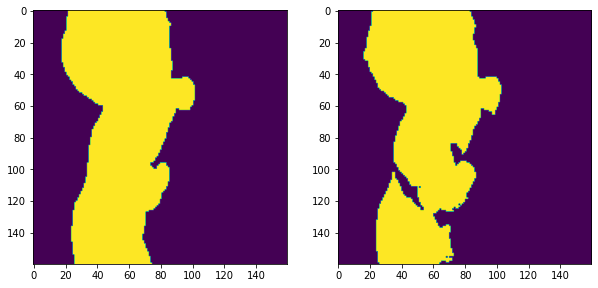

In [32]:
import matplotlib.pyplot as plt

for  i in range(20):                                             
    #original image
    gt_image = np.argmax(np.reshape(test_dataloader[i][1][2],(160,160,2)),axis=-1)
   
    #predicted saliency map                                                                                                                                                                                                        
    r,d,final = model2.predict(test_dataloader[i][0])
    final=np.argmax(final,axis=-1)



    plt.figure(figsize=(10,6))
    plt.subplot(121)
    plt.imshow(gt_image)
    plt.subplot(122)
    plt.imshow(np.reshape(final,(160,160)))
    print('E_score:',E_score(np.reshape(gt_image,(1,160,160)),np.reshape(final,(1,160,160))))                                                           
    plt.show()